# Readmition predictor project
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

In [483]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# 1. read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 

# List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/

In [484]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col = 0)

In [485]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In this dataframe the missing values are marked as '?'
First We will change in to nan

In [486]:
df.replace('?', np.nan, inplace=True)

We want to know which columns have missing values.:

In [487]:

missing_info = df.info()

# Extract column-wise missing values
missing_values = df.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_values[missing_values > 0].index.tolist()

# Calculate percentage of missing values for each column
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame to display the information
missing_info_df = pd.DataFrame({
    'Column': columns_with_missing,
    'Missing Count': missing_values[columns_with_missing],
    'Missing Percentage': missing_percentage[columns_with_missing]
})

# Print the DataFrame
print(missing_info_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.

<Axes: xlabel='weight', ylabel='count'>

Text(0, 10, '1.3%')

Text(0, 10, '0.9%')

Text(0, 10, '0.6%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0.5, 1.0, 'Histogram of weight')

Text(0.5, 0, 'weight')

Text(0, 0.5, 'percent')

<Axes: xlabel='payer_code', ylabel='count'>

Text(0, 10, '31.9%')

Text(0, 10, '6.2%')

Text(0, 10, '4.9%')

Text(0, 10, '4.6%')

Text(0, 10, '3.5%')

Text(0, 10, '2.5%')

Text(0, 10, '2.4%')

Text(0, 10, '1.9%')

Text(0, 10, '1.0%')

Text(0, 10, '0.6%')

Text(0, 10, '0.5%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.0%')

Text(0.5, 1.0, 'Histogram of payer_code')

Text(0.5, 0, 'payer_code')

Text(0, 0.5, 'percent')

<Axes: xlabel='medical_specialty', ylabel='count'>

Text(0, 10, '14.4%')

Text(0, 10, '7.4%')

Text(0, 10, '7.3%')

Text(0, 10, '5.3%')

Text(0, 10, '3.0%')

Text(0, 10, '1.6%')

Text(0, 10, '1.4%')

Text(0, 10, '1.2%')

Text(0, 10, '1.1%')

Text(0, 10, '0.9%')

Text(0, 10, '0.8%')

Text(0, 10, '0.7%')

Text(0, 10, '0.7%')

Text(0, 10, '0.6%')

Text(0, 10, '0.6%')

Text(0, 10, '0.5%')

Text(0, 10, '0.5%')

Text(0, 10, '0.4%')

Text(0, 10, '0.3%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0.5, 1.0, 'Histogram of medical_specialty')

Text(0.5, 0, 'medical_specialty')

Text(0, 0.5, 'percent')

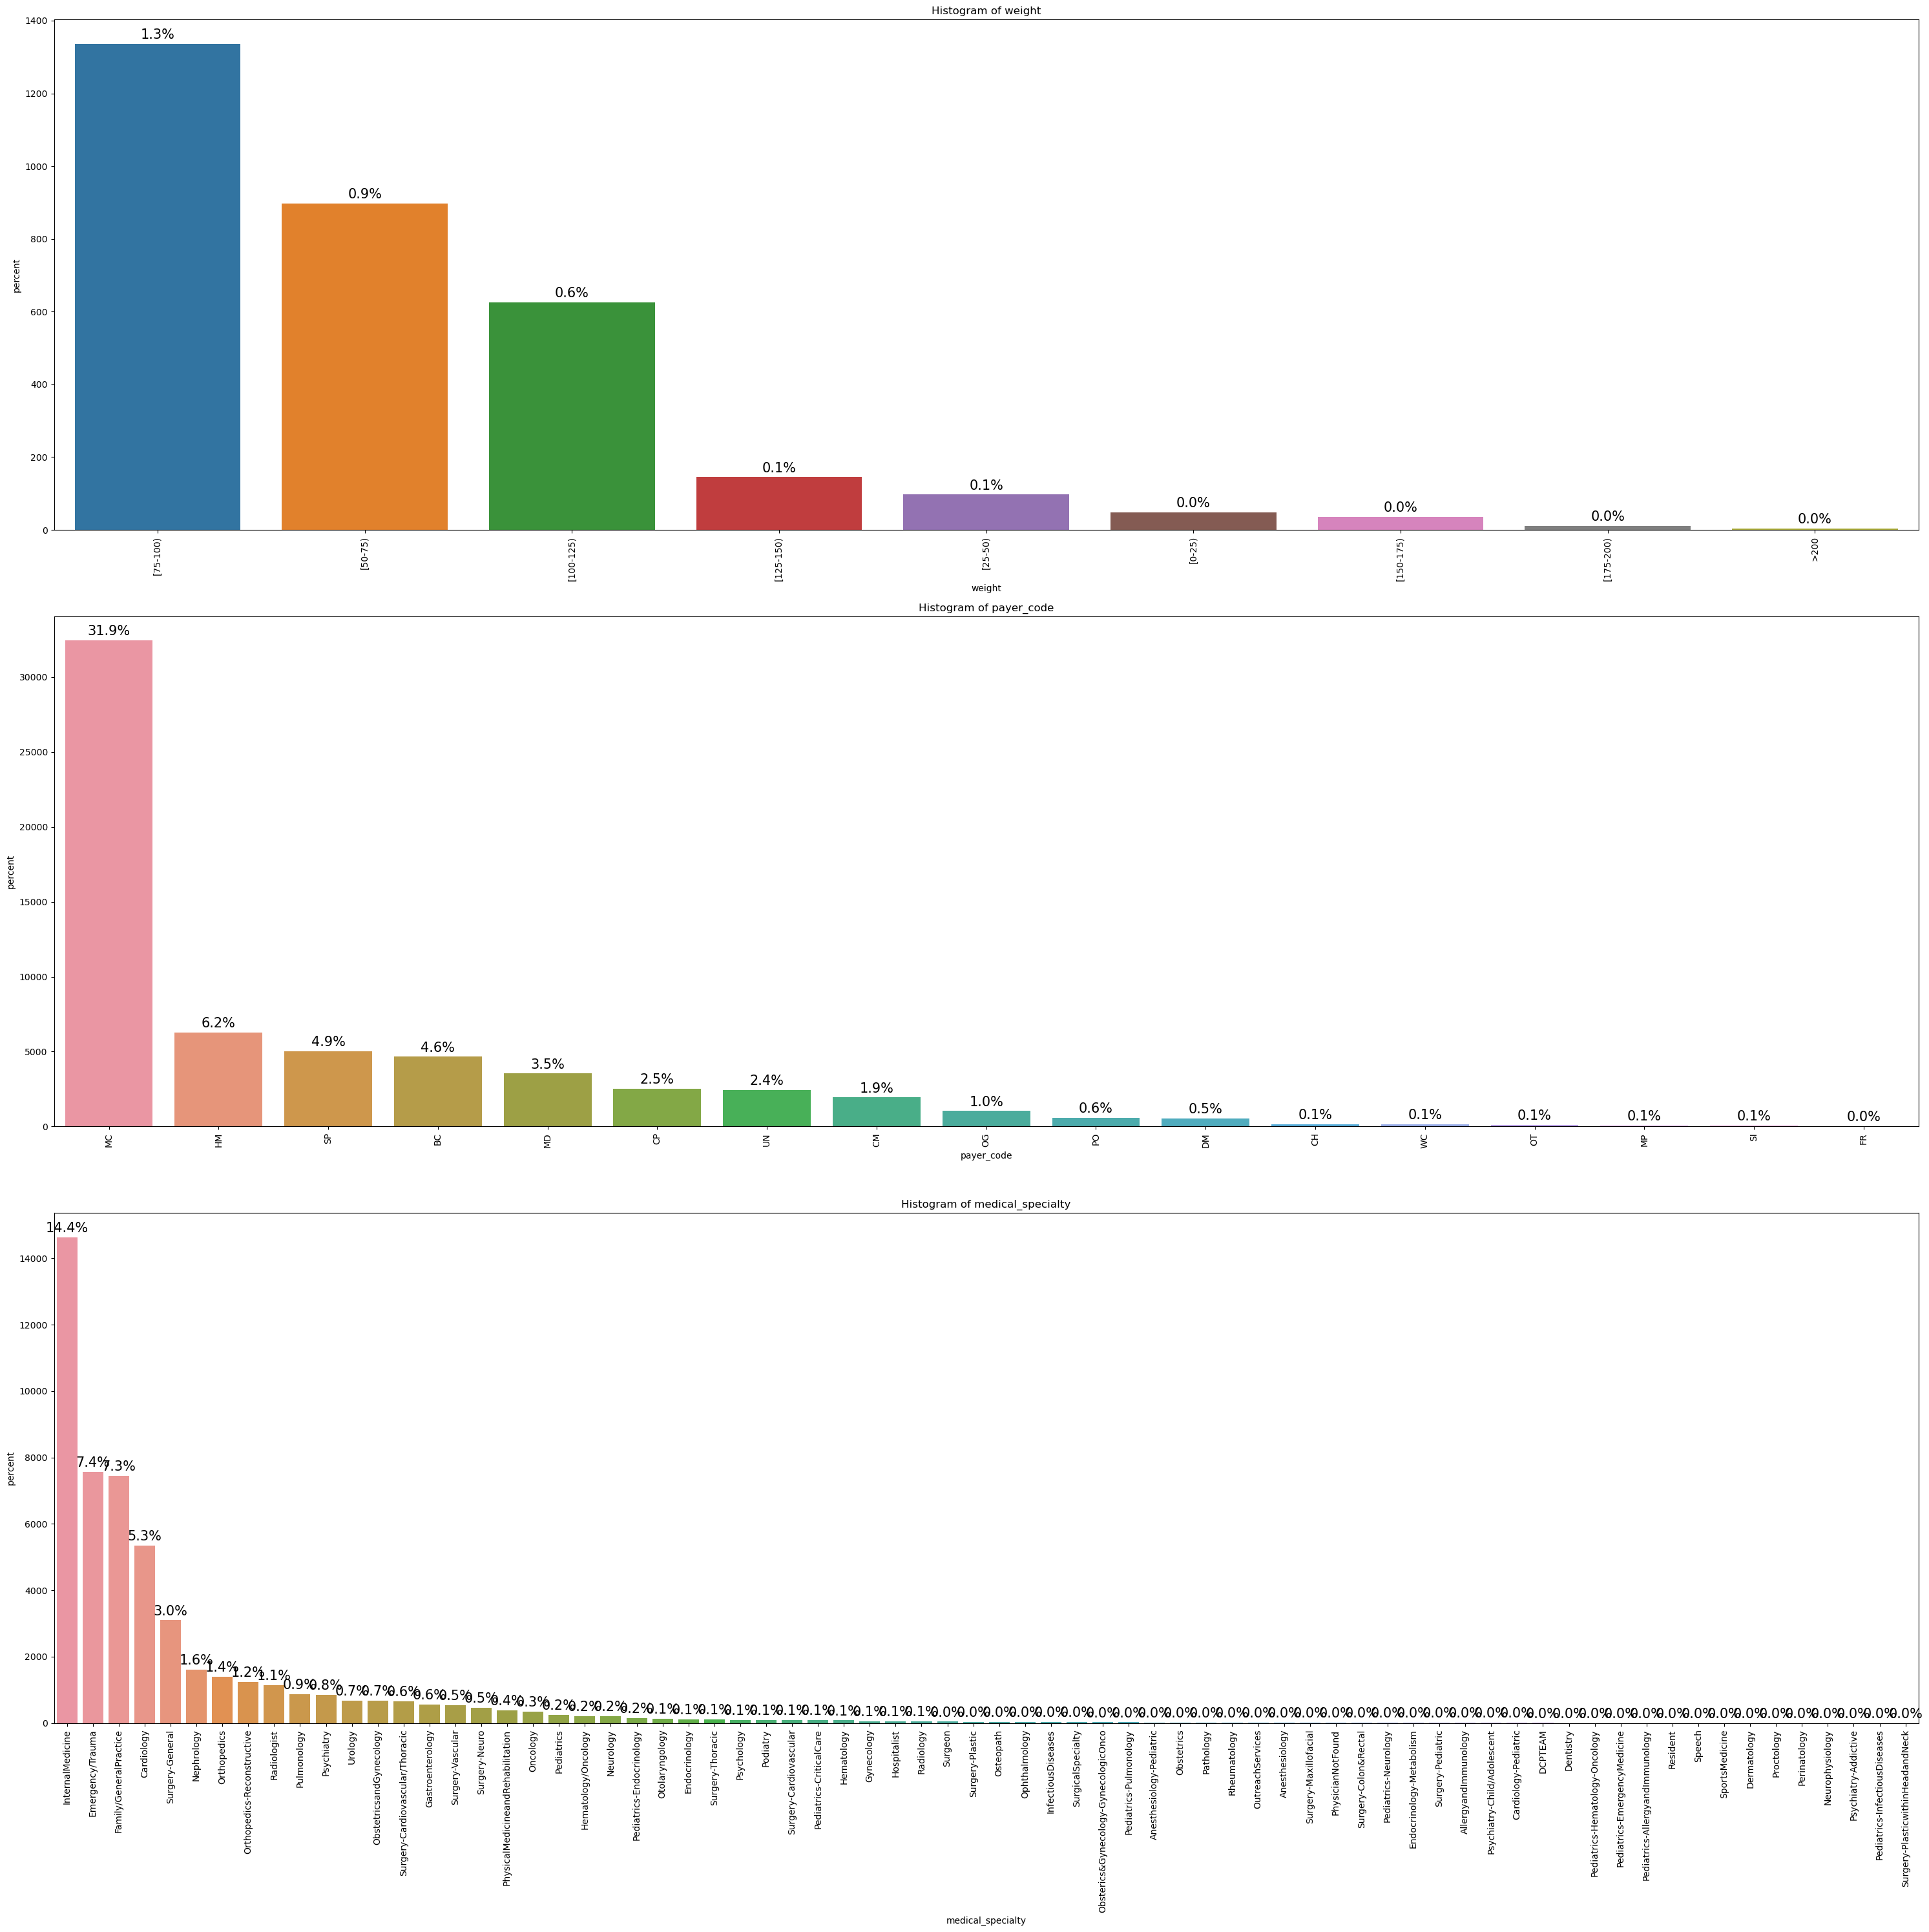

In [488]:
columns = ['weight', 'payer_code', 'medical_specialty']
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(30, 30))

# Plot histograms for each column
for i, column in enumerate(columns):

    order = df[column].value_counts().index
    sns.countplot(df, x=column, ax=axes[i], order=order)
    
    for p in axes[i].patches:
        percentage = f"{p.get_height() / len(df) * 100:.1f}%"
        axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15)

    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_ylabel('percent')

plt.tight_layout()
plt.show()

<Axes: xlabel='medical_specialty', ylabel='count'>

Text(0, 10, '49.1%')

Text(0, 10, '14.4%')

Text(0, 10, '7.4%')

Text(0, 10, '7.3%')

Text(0, 10, '5.3%')

Text(0, 10, '3.0%')

Text(0, 10, '1.6%')

Text(0, 10, '1.4%')

Text(0, 10, '1.2%')

Text(0, 10, '1.1%')

Text(0, 10, '0.9%')

Text(0, 10, '0.8%')

Text(0, 10, '0.7%')

Text(0, 10, '0.7%')

Text(0, 10, '0.6%')

Text(0, 10, '0.6%')

Text(0, 10, '0.5%')

Text(0, 10, '0.5%')

Text(0, 10, '0.4%')

Text(0, 10, '0.3%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.2%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.1%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0, 10, '0.0%')

Text(0.5, 1.0, 'Countplot of medical_specialty')

Text(0.5, 0, 'medical_specialty')

Text(0, 0.5, 'Count')

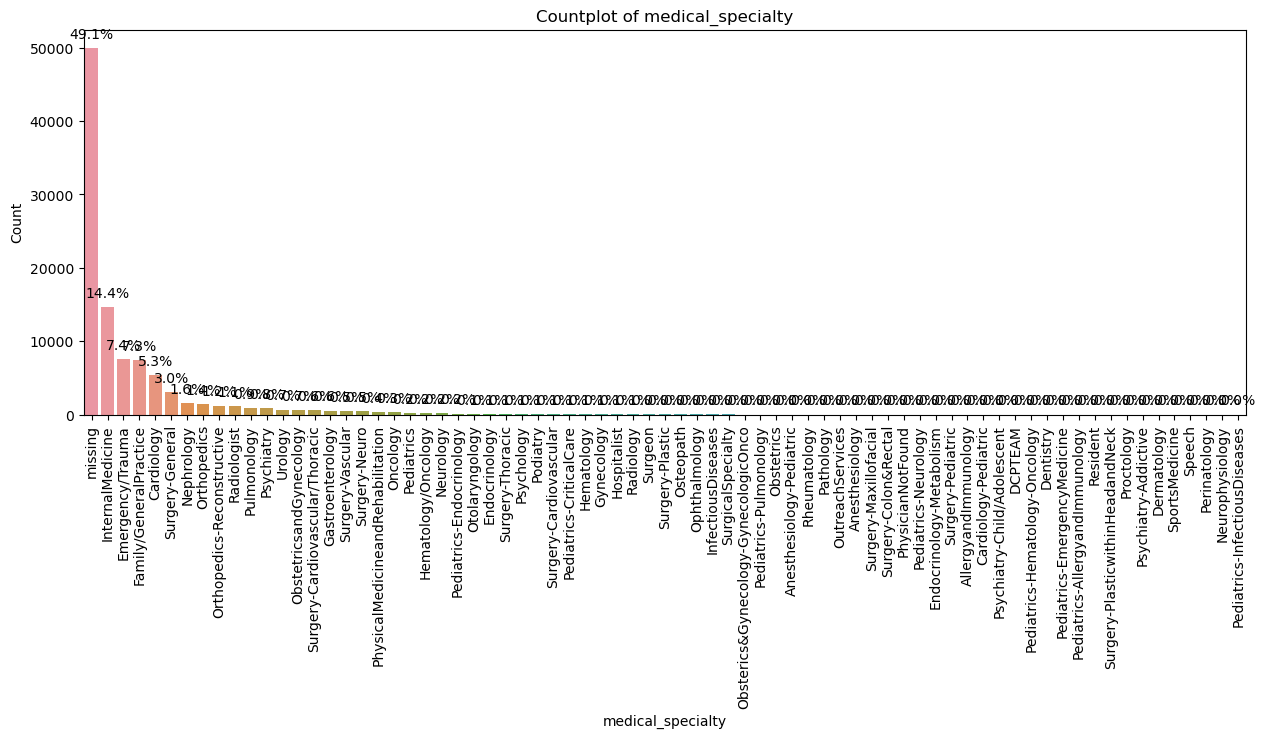

In [489]:
def drop_missing_features(df):
    try:
        df.drop(columns=['weight', 'payer_code'], inplace=True)
    except KeyError:
        ''
    df.loc[~df.medical_specialty.notna(), 'medical_specialty'] = 'missing'
    return df
    
df = drop_missing_features(df)
# print(np.unique(df.medical_specialty, return_counts=True))

column = 'medical_specialty'

order = df[column].value_counts().index

# Create a single subplot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Plot countplot
sns.countplot(data=df, x=column, order=order, ax=axes)

# Annotate bars with percentages
for p in axes.patches:
    percentage = f"{p.get_height() / len(df) * 100:.1f}%"
    axes.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# Set title and labels
axes.set_title(f'Countplot of {column}')
axes.set_xlabel(column)
axes.set_ylabel('Count')
axes.tick_params(axis='x', rotation=90)

plt.show()

In [490]:
num_of_sample, num_of_featuers = df.shape
print(f'Number of samples: {num_of_sample}, number of features: {num_of_featuers}')

df.head()

Number of samples: 101766, number of features: 47


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),1,1,7,3,missing,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,missing,11,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),1,1,7,2,missing,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),1,1,7,1,missing,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


We are going to use 'readmission' as our label in a binary classification problem.
First, we need to understand how the 'readmitted' variable is distributed.

1. Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.
2. Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

<Axes: >

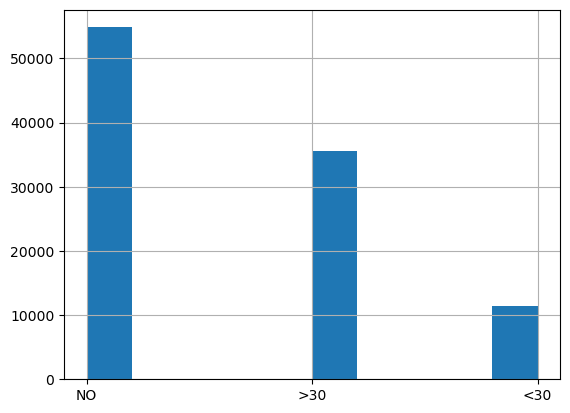

In [425]:
df.readmitted.hist()

In [491]:
# First we will start by removing the cases associated with death or hospice
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
num_of_sample, num_of_featuers = df.shape
print(f'Number of samples: {num_of_sample}, number of features: {num_of_featuers}')

Number of samples: 99343, number of features: 47


In [492]:
# Then we are fixing the readmittion to readmitted if <30 or otherwise
def fix_readmitted_values(df):
    ''' we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise”'''
    df.loc[df.readmitted == '<30', 'readmitted'] = 'readmitted'
    df.loc[df.readmitted != 'readmitted', 'readmitted'] = 'otherwise'
    return df

df = fix_readmitted_values(df)

readmitted_size = df.groupby('readmitted').size()
readmitted_size

readmitted
otherwise     88029
readmitted    11314
dtype: int64

<Axes: >

Text(0.5, 1.0, 'Readmitted: 11% of the total data')

Text(0.5, 0, 'Readmitted')

Text(0, 0.5, 'Count')

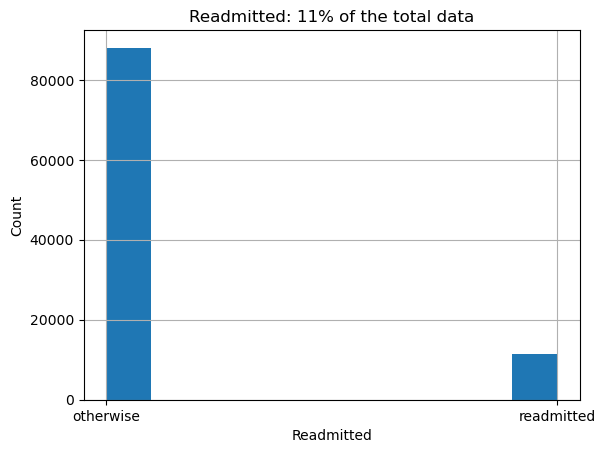

In [493]:
percent_of_readmitted = (readmitted_size.loc['readmitted'] / np.sum(readmitted_size.values)) * 100
df.readmitted.hist()

plt.title(f'Readmitted: {round(percent_of_readmitted)}% of the total data')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()


## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered statistically independent, an assumption of the logistic regression model. We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days. Additionally, we removed all encounters that resulted in either discharge to a hospice or patient death

In [430]:
# lets look at the couloums valuse and types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99343 entries, 2278392 to 443867222
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               99343 non-null  int64 
 1   race                      97109 non-null  object
 2   gender                    99343 non-null  object
 3   age                       99343 non-null  object
 4   admission_type_id         99343 non-null  int64 
 5   discharge_disposition_id  99343 non-null  int64 
 6   admission_source_id       99343 non-null  int64 
 7   time_in_hospital          99343 non-null  int64 
 8   medical_specialty         99343 non-null  object
 9   num_lab_procedures        99343 non-null  int64 
 10  num_procedures            99343 non-null  int64 
 11  num_medications           99343 non-null  int64 
 12  number_outpatient         99343 non-null  int64 
 13  number_emergency          99343 non-null  int64 
 14  number_inpat

In [431]:
df[column].nunique()

73

In [494]:
column_unique_counts = pd.DataFrame(df.nunique().sort_values(), columns=['unique']).reset_index()
column_unique_counts.rename(columns={'index': 'column'}, inplace=True)

def fraction_of_unique_values(column):
    '''gets the fraction and counts for each column in a df, based on df.nunique function'''
    try:
        unique_values, counts = np.unique(df[column], return_counts=True)
    except TypeError:
        unique_values, counts = np.unique(df[column].astype(str), return_counts=True)
        
    fraction = 100 * (counts / sum(counts))
    
    return np.sort(fraction)[::-1], np.sort(counts)[::-1]

# Apply the function to each row
column_unique_counts[['fraction_of_unique_values', 'counts']] = pd.DataFrame(column_unique_counts['column'].apply(fraction_of_unique_values).apply(pd.Series))

print(column_unique_counts)


                      column  unique  \
0                    examide       1   
1                citoglipton       1   
2                 readmitted       2   
3              acetohexamide       2   
4                tolbutamide       2   
5               troglitazone       2   
6                diabetesMed       2   
7   glimepiride-pioglitazone       2   
8    metformin-rosiglitazone       2   
9                     change       2   
10    metformin-pioglitazone       2   
11       glipizide-metformin       2   
12                tolazamide       3   
13                    gender       3   
14               glimepiride       4   
15                 glipizide       4   
16                 glyburide       4   
17       glyburide-metformin       4   
18                  acarbose       4   
19                  miglitol       4   
20            chlorpropamide       4   
21                   insulin       4   
22              pioglitazone       4   
23             rosiglitazone       4   


In [433]:
column_unique_counts.sort_values

<bound method DataFrame.sort_values of                       column  unique  \
0                    examide       1   
1                citoglipton       1   
2                 readmitted       2   
3              acetohexamide       2   
4                tolbutamide       2   
5               troglitazone       2   
6                diabetesMed       2   
7   glimepiride-pioglitazone       2   
8    metformin-rosiglitazone       2   
9                     change       2   
10    metformin-pioglitazone       2   
11       glipizide-metformin       2   
12                tolazamide       3   
13                    gender       3   
14               glimepiride       4   
15                 glipizide       4   
16                 glyburide       4   
17       glyburide-metformin       4   
18                  acarbose       4   
19                  miglitol       4   
20            chlorpropamide       4   
21                   insulin       4   
22              pioglitazone       4   
2

In [495]:
# lets loo at all the couloumns that have only two unique values
column_unique_counts[column_unique_counts.unique==2]

# We can see that may columns may have 2 unique values but the fraction of each value is neglible, we will remove this features

,column,unique,fraction_of_unique_values,counts
2,readmitted,2,"[88.611175422526, 11.388824577474004]","[88029, 11314]"
3,acetohexamide,2,"[99.99899338654963, 0.0010066134503689237]","[99342, 1]"
4,tolbutamide,2,"[99.97886111754225, 0.0211388824577474]","[99322, 21]"
5,troglitazone,2,"[99.9969801596489, 0.0030198403511067715]","[99340, 3]"
6,diabetesMed,2,"[77.22637729885346, 22.773622701146532]","[76719, 22624]"
7,glimepiride-pioglitazone,2,"[99.99899338654963, 0.0010066134503689237]","[99342, 1]"
8,metformin-rosiglitazone,2,"[99.99798677309926, 0.0020132269007378475]","[99341, 2]"
9,change,2,"[53.5729744420845, 46.4270255579155]","[53221, 46122]"
10,metformin-pioglitazone,2,"[99.99899338654963, 0.0010066134503689237]","[99342, 1]"
11,glipizide-metformin,2,"[99.9869140251452, 0.01308597485479601]","[99330, 13]"


In [435]:
column_unique_counts.fraction_of_unique_values.iloc[0]

array([100.])

In [496]:
# Looking at the percentage of unique values in each column, we decided to examine all columns where one of the values comprises more than 95 percent of the data. and remove the columns
threshold = 95
def is_one_of_the_values_have_bigger_fraction_then(fraction, threshold):
    '''cheack if a value in a list is bigger of threshold, return bool'''
    return (fraction > threshold).any()

coloumn_with_bed_value_destribution = column_unique_counts.apply(lambda row: is_one_of_the_values_have_bigger_fraction_then(row.fraction_of_unique_values, 95), axis=1)
coloumns_to_remove = column_unique_counts[coloumn_with_bed_value_destribution].column.values
coloumns_to_remove

df_witout_bed_columns = df.drop(columns=coloumns_to_remove)

array(['examide', 'citoglipton', 'acetohexamide', 'tolbutamide',
       'troglitazone', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone',
       'glipizide-metformin', 'tolazamide', 'glyburide-metformin',
       'acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
       'repaglinide'], dtype=object)

In [498]:
df_witout_bed_columns.shape

(99343, 31)

In [499]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
values = df_witout_bed_columns[['diag_1','diag_2','diag_3']].values.flatten()
unique_values, counts = np.unique(values.astype(str), return_counts=True)
unique_values, counts
len(unique_values)

(array(['10', '11', '110', '111', '112', '114', '115', '117', '122', '123',
        '131', '132', '133', '135', '136', '137', '138', '139', '14',
        '140', '141', '142', '143', '145', '146', '147', '148', '149',
        '150', '151', '152', '153', '154', '155', '156', '157', '158',
        '160', '161', '162', '163', '164', '17', '170', '171', '172',
        '173', '174', '175', '179', '180', '182', '183', '184', '185',
        '186', '187', '188', '189', '191', '192', '193', '194', '195',
        '196', '197', '198', '199', '200', '201', '202', '203', '204',
        '205', '207', '208', '210', '211', '212', '214', '215', '216',
        '217', '218', '219', '220', '223', '225', '226', '227', '228',
        '229', '23', '230', '232', '233', '235', '236', '237', '238',
        '239', '240', '241', '242', '243', '244', '245', '246', '250',
        '250.01', '250.02', '250.03', '250.1', '250.11', '250.12',
        '250.13', '250.2', '250.21', '250.22', '250.23', '250.3', '250.31',
   

913

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

1. **First Digit (Numeric):** The first digit represents the category of the disease or condition.

2. **Second and Third Digits (Numeric):** These digits further specify the cause, location, severity, and type of the condition within the category.

3. **Fourth and Fifth Digits (Alphanumeric):** These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

- **401:** This is the category code for hypertensive heart disease.
- **.9:** These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.


In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:
1. 
001–139: Infectious and Parasitic Disease2. s
140–239: Neoplasms (Tumor3. s)
240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers
280–289: Diseases of the Blood and Blood-Forming Or5. gans
290–319: Mental Diso6. rders
320–389: Diseases of the Nervous System and Sense 7. Organs
390–459: Diseases of the Circulatory8.  System
460–519: Diseases of the Respirator9. y System
520–579: Diseases of the Digesti10. ve System
580–629: Diseases of the Genitourin11. ary System
630–679: Complications of Pregnancy, Childbirth, and the12.  Puerperium
680–709: Diseases of the Skin and Subcuta13. neous Tissue
710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue
740–759: Congen15. ital Anomalies
760–779: Certain Conditions Originating in the P16. erinatal Period
780–799: Symptoms, Signs, and Ill-De17. fined Conditions
800–999: Inj18. uoisoning
E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters.
heth servicesjury and Poisoning






if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change
then we will unite al desises that are in the same catagory 
 it to the first three digits only.
we will take only diagnostics that are in 2.5 percent or more in the cases
and we will remove '250' becuse all pationt are diabitic

In [500]:
# changing diag to categoricl data. each patiant can have more then one option

df_witout_bed_columns.reset_index(inplace=True)
daig = df_witout_bed_columns.melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')

diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}


def change_value(value): 
    value = str(value).split('.')[0]
    try:
        
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df_witout_bed_columns.melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')

        
diag.value = daig.apply(lambda row: change_value(row.value), axis=1)
diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

diag=diag>0
diag.astype(int).sum(axis=0)/len(diag) *100

df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


daig__1.0      6.050753
daig__2.0      5.638042
daig__3.0     49.463978
daig__4.0      6.260129
daig__5.0      6.577212
daig__6.0      3.960017
daig__7.0     57.654792
daig__8.0     21.638163
daig__9.0     13.484594
daig__10.0    16.864802
daig__11.0     0.696577
daig__12.0     7.271776
daig__13.0     7.539535
daig__14.0     0.249640
daig__16.0    15.342802
daig__17.0     9.845686
daig__18.0     1.820964
daig__19.0     6.671834
dtype: float64

In [501]:
df_with_diag.keys()

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'daig__1.0', 'daig__2.0', 'daig__3.0', 'daig__4.0', 'daig__5.0',
       'daig__6.0', 'daig__7.0', 'daig__8.0', 'daig__9.0', 'daig__10.0',
       'daig__11.0', 'daig__12.0', 'daig__13.0', 'daig__14.0', 'daig__16.0',
       'daig__17.0', 'daig__18.0', 'daig__19.0'],
      dtype='object')

In [506]:
df_with_diag.head()

,patient_nbr,race,age,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,daig__13.0,daig__14.0,daig__16.0,daig__17.0,daig__18.0,daig__19.0,gender_Female,gender_Male,discharge_home,discharge_other
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,[0-10),6,1,1,Pediatrics-Endocrinology,41,0,1,...,False,False,False,False,False,False,1,0,0,1
149190,55629189,Caucasian,[10-20),1,7,3,missing,59,0,18,...,False,False,False,False,False,False,1,0,1,0
64410,86047875,AfricanAmerican,[20-30),1,7,2,missing,11,5,13,...,False,False,False,False,False,True,1,0,1,0
500364,82442376,Caucasian,[30-40),1,7,2,missing,44,1,16,...,False,False,False,False,False,False,0,1,1,0
16680,42519267,Caucasian,[40-50),1,7,1,missing,51,0,8,...,False,False,False,False,False,False,0,1,1,0


In [502]:
# remove inknown gender
pd.unique(df_with_diag.gender)
df_with_diag = df_with_diag[~ (df_with_diag.gender == 'Unknown/Invalid')]
pd.unique(df_with_diag.gender)
# change gender to categorical
pd.unique(df_with_diag.gender)
df_with_diag = pd.get_dummies(df_with_diag, columns=['gender'], prefix_sep='_')


array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

array(['Female', 'Male'], dtype=object)

array(['Female', 'Male'], dtype=object)

In [505]:
# change the discharge to categorical, reduce to home/other
np.unique(df_with_diag.discharge_disposition_id, return_counts=True)
df_with_diag.loc[df_with_diag.discharge_disposition_id != 1, 'discharge_disposition_id'] = 'other'
df_with_diag.loc[df_with_diag.discharge_disposition_id == 1, 'discharge_disposition_id'] = 'home'
df_with_diag.rename(columns={'discharge_disposition_id': 'discharge'}, inplace=True)
np.unique(df_with_diag.discharge, return_counts=True)
df_with_diag = pd.get_dummies(df_with_diag, columns=['discharge'], prefix_sep='_')

(array(['home', 'other'], dtype=object), array([60232, 39108], dtype=int64))

In [442]:
# change the admission to categorical, reduce to other, high_prayority, clinic_referral
# admission_type_id	description
# 1	Emergency
# 2	Urgent
# 3	Elective
# 4	Newborn
# 5	Not Available
# 6	NULL
# 7	Trauma Center
# 8	Not Mapped
# we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral

np.unique(df_with_diag.admission_type_id, return_counts=True)
df_with_diag.loc[df_with_diag.admission_type_id.isin([5,6,8]), 'admission_type_id'] = 'other'
df_with_diag.loc[df_with_diag.admission_type_id.isin([1,2]), 'admission_type_id'] = 'high_prayority'
df_with_diag.loc[df_with_diag.admission_type_id.isin([3,4,7]), 'admission_type_id'] = 'clinic_referral'
df_with_diag.rename(columns={'admission_type_id': 'admission'}, inplace=True)
np.unique(df_with_diag.admission, return_counts=True)
df_with_diag = pd.get_dummies(df_with_diag, columns=['admission'], prefix_sep='_')




(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([52369, 18132, 18667,    10,  4617,  5207,    18,   320],
       dtype=int64))

(array(['clinic_referral', 'high_prayority', 'other'], dtype=object),
 array([18695, 70501, 10144], dtype=int64))

In [443]:
df_with_diag.keys()

Index(['patient_nbr', 'race', 'age', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'daig__1.0', 'daig__2.0', 'daig__3.0', 'daig__4.0', 'daig__5.0',
       'daig__6.0', 'daig__7.0', 'daig__8.0', 'daig__9.0', 'daig__10.0',
       'daig__11.0', 'daig__12.0', 'daig__13.0', 'daig__14.0', 'daig__16.0',
       'daig__17.0', 'daig__18.0', 'daig__19.0', 'gender_Female',
       'gender_Male', 'discharge_home', 'discharge_other',
       'admission_clinic_referral', 'admission_high_prayority',
       'admission_other'],
      dtype='object')

In [444]:
# we change race to categorical dou low amout of asian and hispanic are unite with other, nan values are changed to missing
np.unique(df_with_diag.race.astype(str), return_counts=True)
df_with_diag.loc[df_with_diag.race.isna(), 'race'] ='missing'
df_with_diag.loc[df_with_diag.race.isin(['Asian', 'Hispanic','Other']), 'race'] ='other'
np.unique(df_with_diag.race.astype(str), return_counts=True)
df_with_diag = pd.get_dummies(df_with_diag, columns=['race'], prefix_sep='_')


(array(['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other',
        'nan'], dtype=object),
 array([18772,   628, 74220,  2017,  1471,  2232], dtype=int64))

(array(['AfricanAmerican', 'Caucasian', 'missing', 'other'], dtype=object),
 array([18772, 74220,  2232,  4116], dtype=int64))

In [446]:
# age groups are divided to tree: yung- <30, midlife 30<60 and old 60+ and turn to categorical
np.unique(df_with_diag.age.astype(str), return_counts=True)
df_with_diag.loc[df_with_diag.age.isin(['[0-10)', '[10-20)', '[20-30)']), 'age'] ='<30'
df_with_diag.loc[df_with_diag.age.isin(['[30-40)', '[40-50)', '[50-60)']), 'age'] ='30<60'
df_with_diag.loc[df_with_diag.age.isin(['[60-70)', '[70-80)', '[80-90)', '[90-100)']), 'age'] ='>60'
np.unique(df_with_diag.age.astype(str), return_counts=True)
df_with_diag = pd.get_dummies(df_with_diag, columns=['age'], prefix_sep='_')



AttributeError: 'DataFrame' object has no attribute 'age'

In [447]:
np.unique(df_with_diag.time_in_hospital, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int64),
 array([13822, 16891, 17432, 13684,  9749,  7355,  5696,  4270,  2879,
         2262,  1770,  1383,  1152,   995], dtype=int64))

In [448]:
df_with_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   patient_nbr                99340 non-null  int64 
 1   admission_source_id        99340 non-null  int64 
 2   time_in_hospital           99340 non-null  int64 
 3   medical_specialty          99340 non-null  object
 4   num_lab_procedures         99340 non-null  int64 
 5   num_procedures             99340 non-null  int64 
 6   num_medications            99340 non-null  int64 
 7   number_outpatient          99340 non-null  int64 
 8   number_emergency           99340 non-null  int64 
 9   number_inpatient           99340 non-null  int64 
 10  number_diagnoses           99340 non-null  int64 
 11  max_glu_serum              99340 non-null  object
 12  A1Cresult                  99340 non-null  object
 13  metformin                  99340 non-null  object
 

In [457]:
sorted_unique[:7]

array(['missing', 'InternalMedicine', 'Emergency/Trauma',
       'Family/GeneralPractice', 'Cardiology', 'Norm', 'Surgery-General'],
      dtype=object)

In [458]:
# catagories medical specialety
unique, counts = np.unique(df.medical_specialty.astype(str), return_counts=True)
sorted_indices = np.argsort(counts)[::-1]  # Reverse order to get descending sort indices
sorted_unique = unique[sorted_indices]
sorted_counts = counts[sorted_indices]
sorted_unique, sorted_counts
# we will take all 6 top type of specialeties and missing and we are creating new type : 'other'

df_with_diag.loc[~(df_with_diag.medical_specialty.isin(sorted_unique[:7])), 'medical_specialty'] ='other'
np.unique(df.medical_specialty.astype(str), return_counts=True)
df_with_diag = pd.get_dummies(df_with_diag, columns=['medical_specialty'], prefix_sep='_')

(array(['missing', 'InternalMedicine', 'Emergency/Trauma',
        'Family/GeneralPractice', 'Cardiology', 'Norm', 'Surgery-General',
        'Nephrology', 'Orthopedics', 'Orthopedics-Reconstructive',
        'Radiologist', 'Pulmonology', 'Psychiatry', 'Urology',
        'ObstetricsandGynecology', 'Surgery-Cardiovascular/Thoracic',
        'Gastroenterology', 'Surgery-Vascular', 'Surgery-Neuro',
        'PhysicalMedicineandRehabilitation', 'Oncology', 'Pediatrics',
        'Neurology', 'Hematology/Oncology', 'Pediatrics-Endocrinology',
        'Otolaryngology', 'Endocrinology', 'Surgery-Thoracic', 'Podiatry',
        'Psychology', 'Surgery-Cardiovascular', 'Pediatrics-CriticalCare',
        'Hematology', 'Gynecology', 'Hospitalist', 'Radiology', 'Surgeon',
        'Surgery-Plastic', 'Osteopath', 'Ophthalmology',
        'InfectiousDiseases', 'SurgicalSpecialty',
        'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
        'Pediatrics-Pulmonology', 'Anesthesiology-Pediatric',
 

(array(['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
        'InternalMedicine', 'Norm', 'Surgery-General', 'missing', 'other'],
       dtype=object),
 array([ 5090,  7014,  6934, 13516,  4922,  2954, 45903, 13007],
       dtype=int64))

# Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


In [459]:
df.A1Cresult.hist()

AttributeError: 'DataFrame' object has no attribute 'A1Cresult'

In [460]:
def set_encounters(df):
    '''set encounters for each patient based on  A1C and change in medications'''
    df['encounters'] = 'None'
    df.loc[(df.A1Cresult == '>7') | (df.A1Cresult == '>8'), 'encounters'] = '7_No'
    df.loc[((df.A1Cresult == '>7') | (df.A1Cresult == '>8')) & (df.change == 'Ch'), 'encounters'] = '7_Ch'
    df.loc[df.A1Cresult == 'Norm'] = 'Norm'
    df.drop(columns=['A1Cresult', 'change'], inplace=True)
    return df
df = set_encounters(df_with_diag)
np.unique(df.encounters, return_counts=True)

AttributeError: 'DataFrame' object has no attribute 'A1Cresult'

<Axes: xlabel='encounters', ylabel='Percent'>

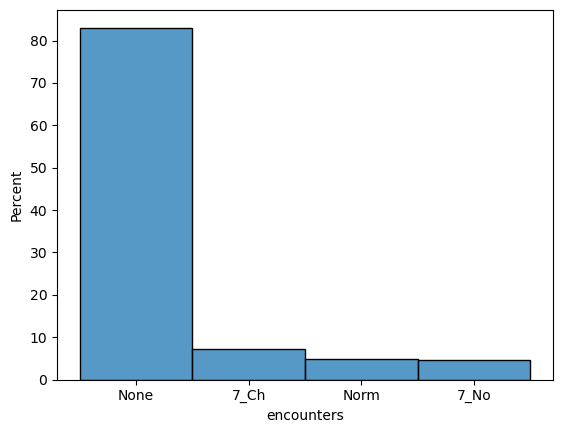

In [451]:
sns.histplot(data=df, x='encounters', stat='percent')

In [452]:
pd.unique(df.medical_specialty)

array(['Pediatrics-Endocrinology', 'missing', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Norm', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'Physica

In [453]:
np.unique(df.insulin)

array(['Down', 'No', 'Norm', 'Steady', 'Up'], dtype=object)

In [472]:
pd.unique(df.num_medications                                                       )

array([ 1, 18, 13, 16,  8, 21, 12, 28, 17, 11, 15, 31,  2, 23, 19,  7, 20,
       14, 10, 22,  9, 27, 25,  4, 32,  6, 30, 26, 24, 33,  5, 39,  3, 29,
       61, 40, 46, 41, 36, 34, 35, 50, 43, 42, 37, 51, 38, 45, 54, 52, 49,
       62, 55, 47, 44, 53, 48, 57, 59, 56, 60, 63, 58, 70, 67, 64, 69, 65,
       68, 66, 81, 79, 75, 72, 74], dtype=int64)

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
